No handles with labels found to put in legend.


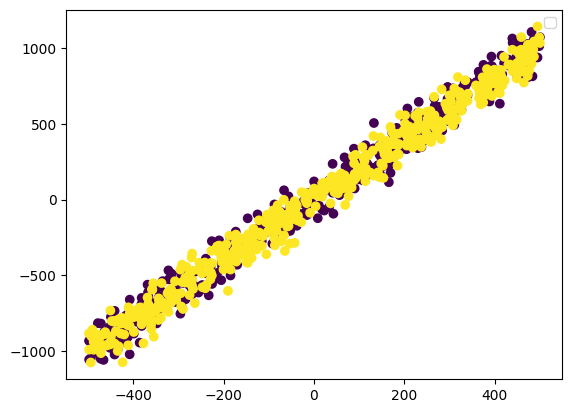

(1000, 1)
(1000, 1)
(1000, 1)


In [182]:
import numpy as np
import matplotlib.pyplot as plt

def func(x, bias):
    m = 2
    
    return (x*m) + bias


n_datapoints = 500

x_range = 500
x_vals = np.random.uniform(-x_range, x_range, size=n_datapoints)

y1_vals = func(x_vals, 0)
y2_vals = func(x_vals, 0)


noise = 75
y1_vals = y1_vals + np.random.normal(0, noise, size=y1_vals.shape)
y2_vals = y2_vals + np.random.normal(0, noise, size=y2_vals.shape)


X = np.concatenate((x_vals, x_vals), axis=0)[:, np.newaxis]
y = np.concatenate((y1_vals, y2_vals), axis=0)[:, np.newaxis]
groups = np.zeros((n_datapoints*2, 1))
groups[0:n_datapoints, 0] = 0
groups[n_datapoints:, 0] = 1


plt.scatter(x=X, y=y, c=groups)
plt.legend()
plt.show()

print(X.shape)
print(y.shape)
print(groups.shape)


In [183]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder().fit(groups)

In [184]:
SEED = 42

Optimization terminated successfully.
         Current function value: 5580.478987
         Iterations: 4
         Function evaluations: 18
         Gradient evaluations: 6
[2.00584613 3.87677393]


/home/miguel/Projects/uni/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/miguel/Projects/uni/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


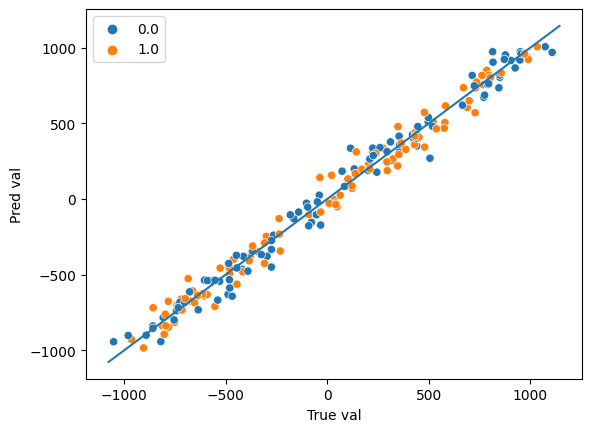

58.016265751667326


In [185]:
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from functools import partial
import seaborn as sns

idx = np.arange(X.shape[0])
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=SEED, stratify=groups)
X_train = X[train_idx]
y_train = y[train_idx]
groups_train = groups[train_idx]

X_test = X[test_idx]
y_test = y[test_idx]
groups_test = groups[test_idx]

n_groups = groups_onehot.shape[1]
# model = LinearRegression()

def model(m, c):
    return lambda x: m*x + c

def _func(params, x, y):
    m, c = params
    model_func = model(m, c)
    return mean_squared_error(model_func(x), y)

func = partial(_func, x=X_train, y=y_train)


x0 = (1, 1)

res = minimize(func, x0, options={'disp': True})
print(res.x)

trained_model = model(*res.x)

y_pred = trained_model(X_test)

sns.scatterplot(y_test.squeeze(), y_pred.squeeze(), hue=groups_test.squeeze())
sns.lineplot([y.min(), y.max()], [y.min(), y.max()])
plt.xlabel('True val')
plt.ylabel('Pred val')
plt.show()

print(mean_absolute_error(y_test, y_pred))


Optimization terminated successfully.
         Current function value: 5510.725399
         Iterations: 7
         Function evaluations: 44
         Gradient evaluations: 11


/home/miguel/Projects/uni/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/miguel/Projects/uni/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


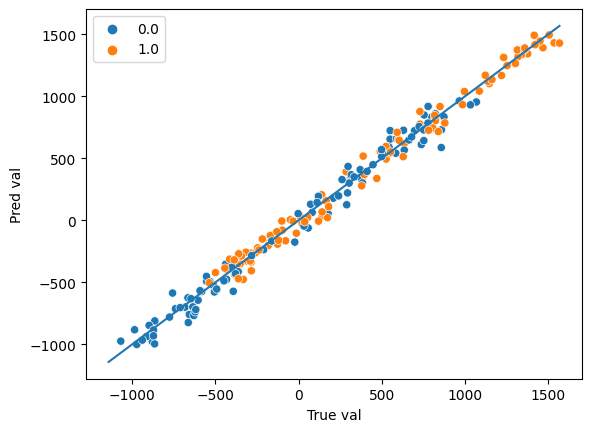

58.47738176750847


In [169]:
# With groups informed

from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from functools import partial
import seaborn as sns

n_groups = groups_onehot.shape[1]


def model(x, g, m, c):
    return (m*x).squeeze() + (g * c).sum(axis=1)

def _func(params, x, groups, y):
    m, c = params[0], np.array(params[1:])[:, np.newaxis]
    model_func = partial(model, m=m, c=c)
    return mean_squared_error(model_func(x, groups), y)

func = partial(_func, x=X_train, groups=encoder.transform(groups_train), y=y_train)

x0 = (1, *np.zeros((n_groups, )).tolist())

res = minimize(func, x0, options={'disp': True})
params = res.x
m, c = params[0], np.array(params[1:])[:, np.newaxis]

trained_model = partial(model, m=m, c=c)

y_pred = trained_model(X_test, encoder.transform(groups_test))

sns.scatterplot(y_test.squeeze(), y_pred.squeeze(), hue=groups_test.squeeze())
sns.lineplot([y.min(), y.max()], [y.min(), y.max()])
plt.xlabel('True val')
plt.ylabel('Pred val')
plt.show()

print(mean_absolute_error(y_test, y_pred))

